<a href="https://colab.research.google.com/github/sobhanshukueian/Face-Identification-using-Siamese/blob/main/Face_Identification_Siam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Face Identification on AT&T
Face identification is the task of matching a given face image to one in an existing database of faces.So how can we solve this problem with siamese networks?
## Siamese Networks


# Dependencies


In [1]:
# %matplotlib inline
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import shutil
import matplotlib
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
BATCH_SIZE = 16 #@param
DATA_SET_PATH = "/content/ATT/" #@param

# AT&T Face Identification Dataset
kaggle URL: https://www.kaggle.com/datasets/kasikrit/att-database-of-faces?resource=download 

## Some Configs for downloading from kaggle : 

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens
2. Click on Create New API Token - It will download kaggle.json file on your machine.
3. Upload file here ⬇


In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
#Upload the token json file 
from google.colab import files
files.upload()
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle (1).json
ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04          11846        349  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           3760         97  1.0              
harshsingh2209/tesla-stock-pricing-20172022                    TESLA stock pricing (2017-2022)                      28KB  2022-09-18 14:56:29            777         28  1.0              
thedevastator/airplane-cras

In [4]:
!kaggle datasets download -d kasikrit/att-database-of-faces

att-database-of-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip "/content/att-database-of-faces.zip" -d $DATA_SET_PATH

Archive:  /content/att-database-of-faces.zip
replace /content/ATT/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Dataset and DataLoader

In [8]:
# Showing images
def show_batch(data, cols = BATCH_SIZE):
    fig, ax = plt.subplots(2, cols, figsize=(cols*10, 2*10))
    for index in range(cols):
        ax[0, index].imshow(data[0][index].view(100, 100), cmap='gray')
        ax[1, index].imshow(data[1][index].view(100, 100), cmap='gray')
    plt.show()
    print("labels: ", data[2].numpy().reshape(-1))
    print("First Pair Class: ", data[3].numpy().reshape(-1))
    print("Second Pair Class: ",data[4].numpy().reshape(-1))

In [9]:
def create_data(size_multiplier, class_num):    
    pair1 = []
    pair2 = []
    labels = []
    label1 = []
    label2 = []

    for _ in range(size_multiplier):
        for i in range(class_num[0], class_num[1]):
            for j in range(class_num[0], class_num[1]):
                if int(i) == int(j):
                    y = 0
                    c = class_num[1] - class_num[0] - 1
                else:
                    y = 1
                    c = 1
                for _ in range(c):
                    label1.append(i)
                    label2.append(j)
                    pair1.append(np.random.randint(1, 11))
                    pair2.append(np.random.randint(1, 11))
                    labels.append(y)
    randomize = np.arange(len(labels))
    np.random.shuffle(randomize)    
    return [pair1, pair2, labels, label1, label2, randomize]

train_data = create_data(size_multiplier=50, class_num=[1, 31])
validation_data = create_data(size_multiplier=15, class_num=[31, 40])


In [10]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, data, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform

        self.pair1 =  data[0]
        self.pair2 =  data[1]
        self.labels = data[2]
        self.label1 = data[3]
        self.label2 = data[4]
        self.randomize = data[5]

    def __getitem__(self, index):
        # print(index)
        index = self.randomize[index]
        label = self.labels[index]
        label0 = self.label1[index]
        label1 = self.label2[index]
        img0 = self.imageFolderDataset + "s"+ str(label0+1) + "/" + str(self.pair1[index]) + ".pgm"
        img1 = self.imageFolderDataset + "s"+ str(label1+1) + "/" + str(self.pair2[index]) + ".pgm"


        img0 = Image.open(img0)
        img1 = Image.open(img1)

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, label, label0, label1
    
    def __len__(self):
        return len(self.labels)

In [11]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(DATA_SET_PATH , train_data, transform=transformation)
siamese_testset = SiameseNetworkDataset(DATA_SET_PATH , validation_data, transform=transformation)

In [12]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset, shuffle=False, num_workers=2, batch_size=BATCH_SIZE)

# Load the testing dataset
test_dataloader = DataLoader(siamese_testset, shuffle=False, num_workers=2, batch_size=BATCH_SIZE)

In [13]:
train_features = next(iter(train_dataloader))
print(len(train_dataloader))
print("Train Images 1 Shape: {}\nTrain Images 2 Shape: {}\nTrain Data Labels Shape: {}".format(train_features[0].shape, train_features[1].shape, train_features[2].shape,))

test_features = next(iter(train_dataloader))
print(len(test_dataloader))
print("Test Images 1 Shape: {}\nTest Images 2 Shape: {}\nTest Data Labels Shape: {}".format(test_features[0].shape, test_features[1].shape, test_features[2].shape,))


5438
Train Images 1 Shape: torch.Size([16, 1, 100, 100])
Train Images 2 Shape: torch.Size([16, 1, 100, 100])
Train Data Labels Shape: torch.Size([16])
135
Test Images 1 Shape: torch.Size([16, 1, 100, 100])
Test Images 2 Shape: torch.Size([16, 1, 100, 100])
Test Data Labels Shape: torch.Size([16])


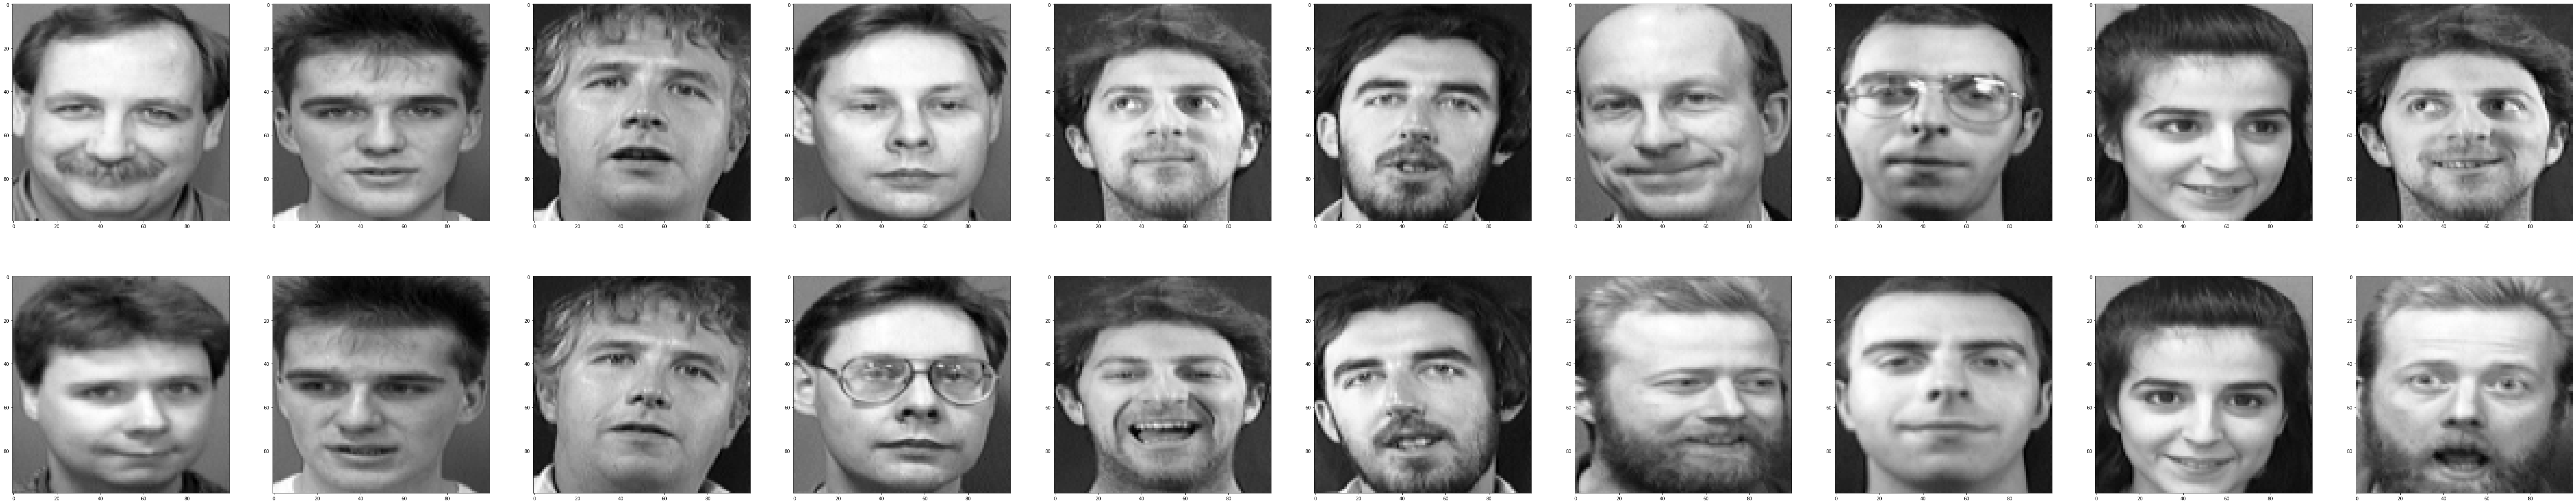

labels:  [1 0 0 0 0 0 1 0 0 1]
First Pair Class:  [24 29 14  3  6 10 12 18  9  6]
Second Pair Class:  [22 29 14  3  6 10 25 18  9 25]


In [14]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=10)

# Extract one batch
example_batch = next(iter(vis_dataloader))
show_batch(example_batch, cols=10)

# Model

In [ ]:
OUTPUT_EMBEDDING_SIZE = 8

#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(6),
            nn.Dropout(),
            
            nn.Conv2d(6, 5, kernel_size=3),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(5),
            nn.Dropout(),

            nn.Conv2d(5, 5, kernel_size=4),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(5),
            nn.Dropout(), 

            nn.Conv2d(5, OUTPUT_EMBEDDING_SIZE, kernel_size=4),
            # nn.BatchNorm2d(OUTPUT_EMBEDDING_SIZE, affine=False)
        )
        # self.cnn2 = nn.Conv2d(10, OUTPUT_EMBEDDING_SIZE, kernel_size=4)
        self.f = nn.Flatten()
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        # output = torch.mul(output, 1.4142135623730950488)
        # output = self.cnn2(output)
        output = self.f(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

    

# Loss 

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidean distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True).squeeze()
        # print(euclidean_distance)
        
        losses = (1-label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)    
        loss_contrastive = torch.mean(losses)
        # print(losses)
        return loss_contrastive, losses, euclidean_distance

# Trainer Class
This class Does the main part of code which is training model, plot the training process and save model each n epochs.

I Defined `CrossEntropy` Loss and `Adam` Optimizer with learning rate 0.001 and 0.999 momentum.

Dp Each training step in `train_step` function and validation step in `val_step` function and whole trining process in 
`train` function.
 
### ⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇ U can See other Configurations BELOW ⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇⬇

In [ ]:
#@title Some Configurations
EPOCHS = 150 #@param {type:"integer"}
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' #@param
VERBOSE = 3 #@param [0, 1, 2, 3] {type:"raw"}
SAVE_PLOTS = True #@param {type:"boolean"}
VISUALIZE_PLOTS = True #@param {type:"boolean"}
SAVE_DIR = "/content/drive/MyDrive/ATT/runs" #@param
MODEL_NAME = "Siamese Face Identification on AT&T dataset" #@param
WEIGHTS = None


In [ ]:
def get_color(idx):
    return list(matplotlib.colors.cnames.keys())[idx]
  
def get_colors(idxs):
    res = []
    for idx in idxs:
      res.append(get_color(idx))
    return res 

Model: SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(6, 5, kernel_size=(3, 3), stride=(1, 1))
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(5, 5, kernel_size=(4, 4), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.5,

  0%|          | 0/5438 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Epoch: 0/100	Train Loss: 0.8309802412986755  : 100%|██████████| 5438/5438 [08:08<00:00, 11.14it/s]
Epoch: 0/100	Train Validation Loss: 0.37193822860717773 : 100%|██████████| 5438/5438 [04:10<00:00, 21.73it/s]
Epoch: 0/100	Validation Loss Loss: 0.7490800023078918  : 100%|██████████| 135/135 [00:06<00:00, 20.35it/s]


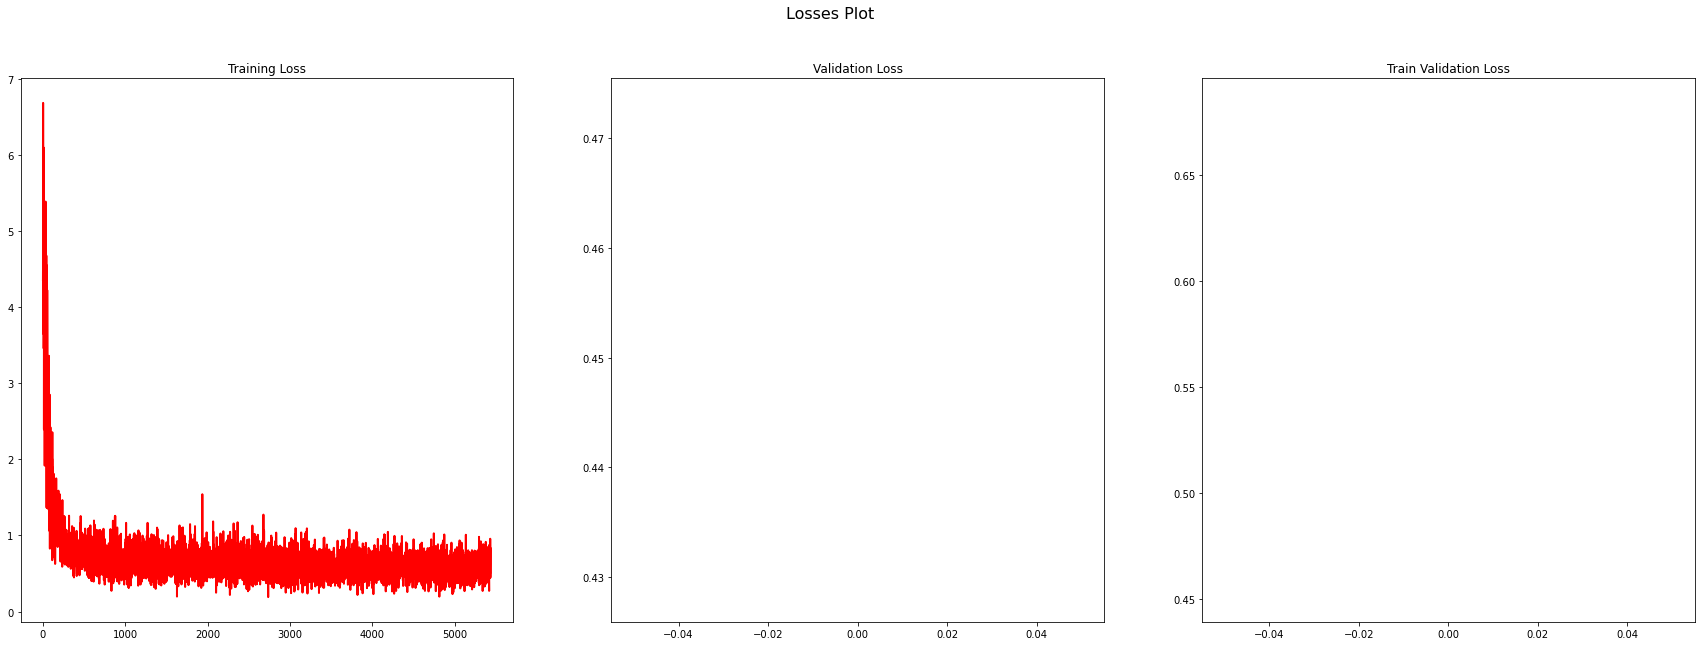

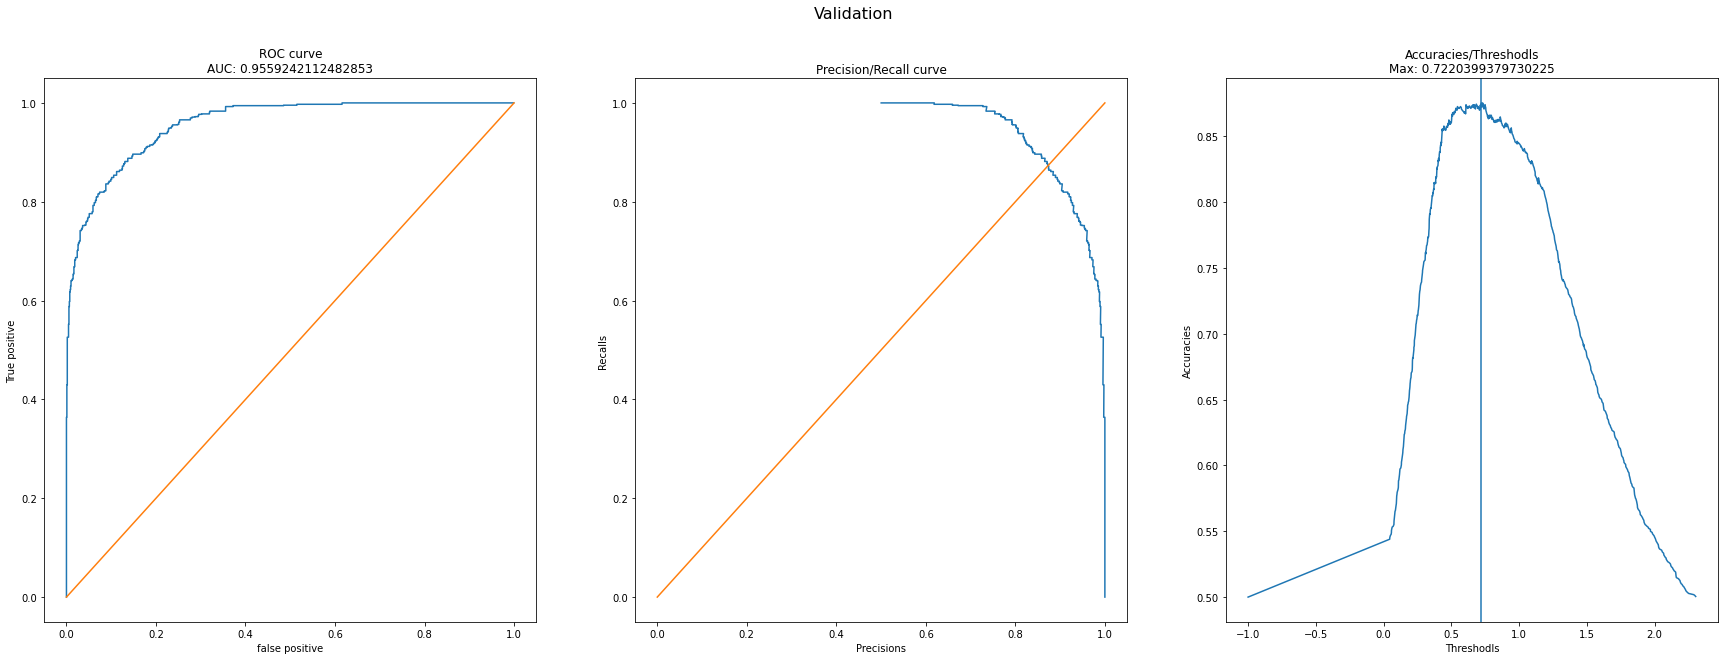

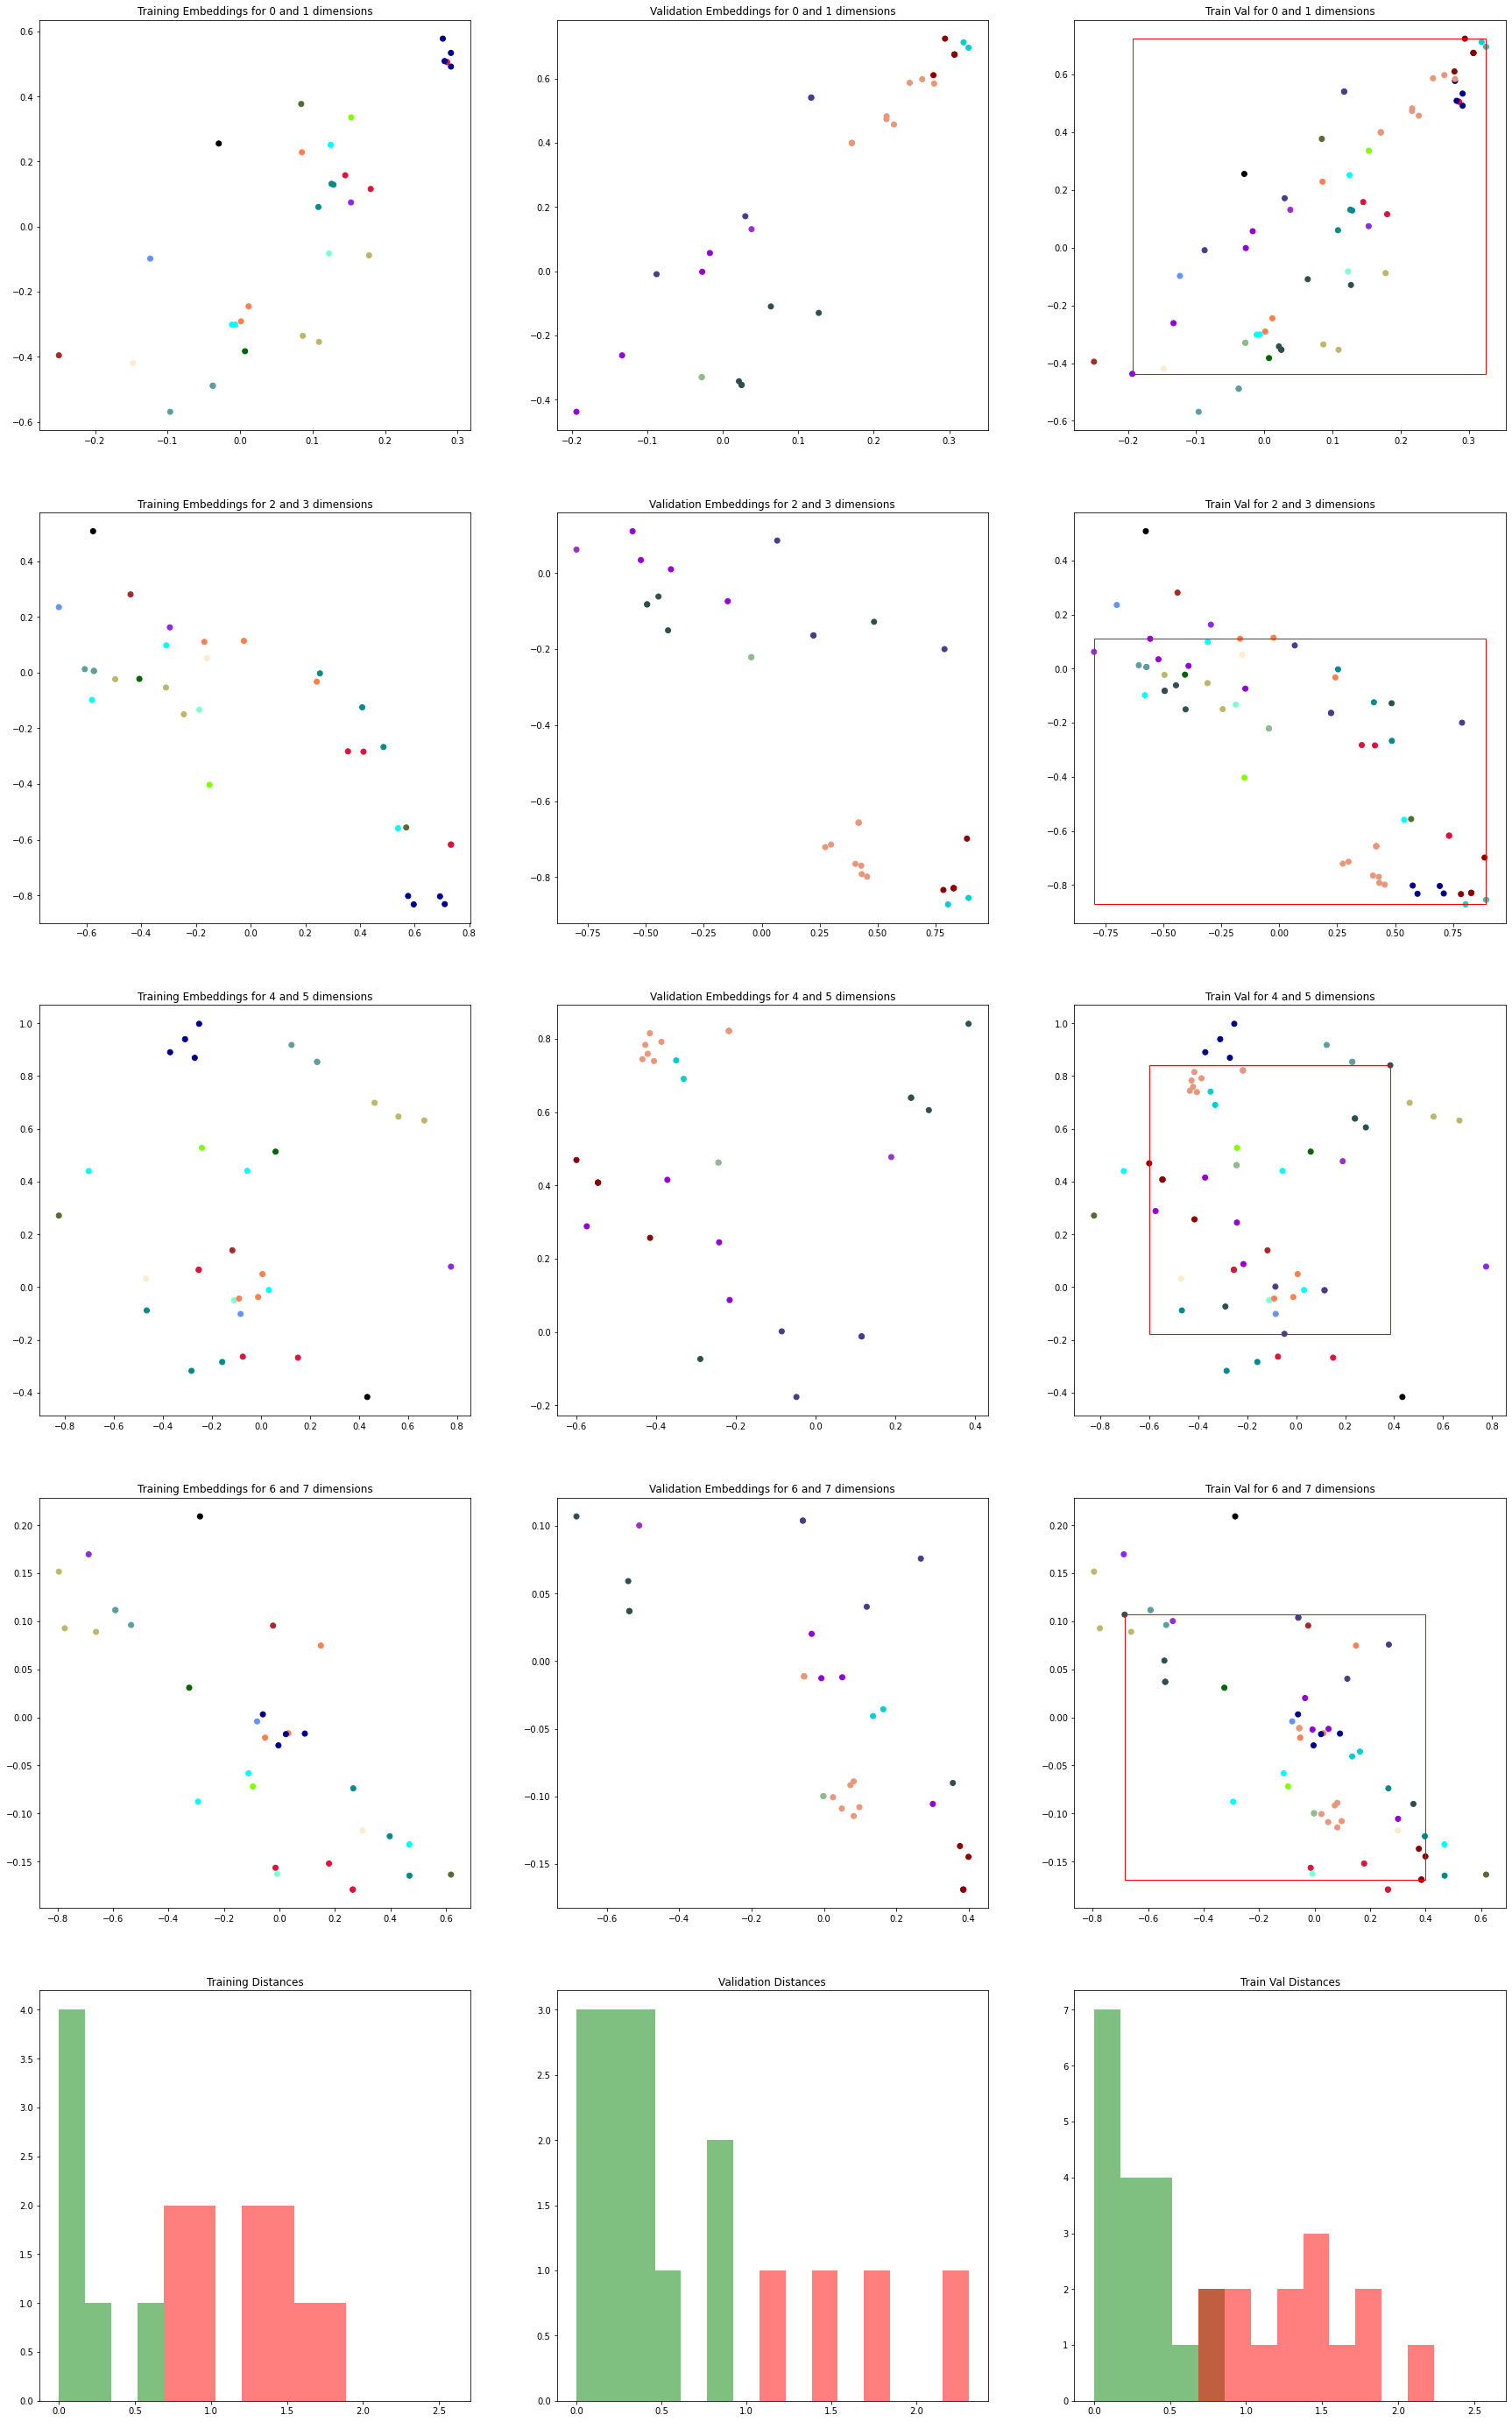

  0%|          | 0/5438 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Epoch: 1/100	Train Loss: 0.33425748348236084  : 100%|██████████| 5438/5438 [07:59<00:00, 11.34it/s]
Epoch: 1/100	Train Validation Loss: 0.19440720975399017 : 100%|██████████| 5438/5438 [04:18<00:00, 21.05it/s]
Epoch: 1/100	Validation Loss Loss: 0.7444509267807007  : 100%|██████████| 135/135 [00:06<00:00, 21.17it/s]


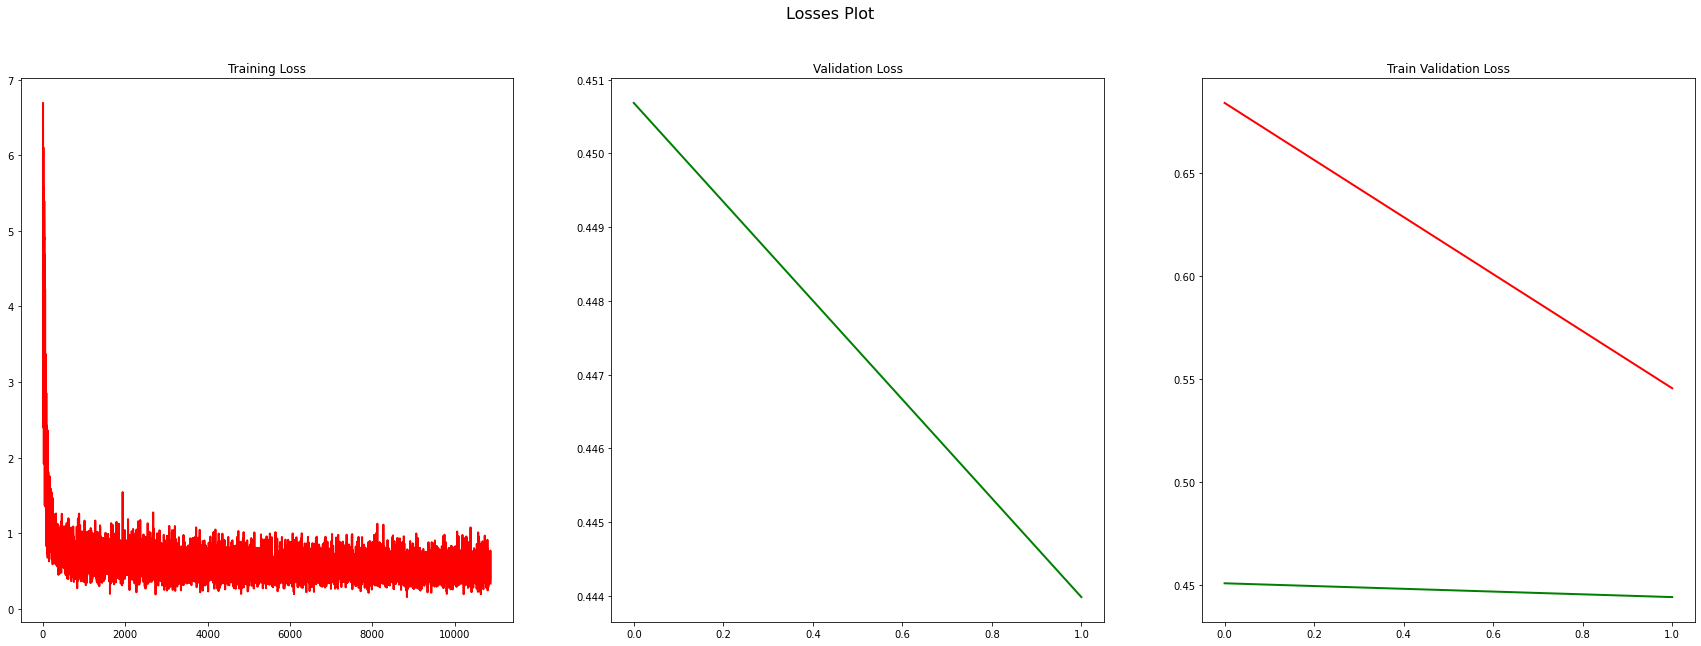

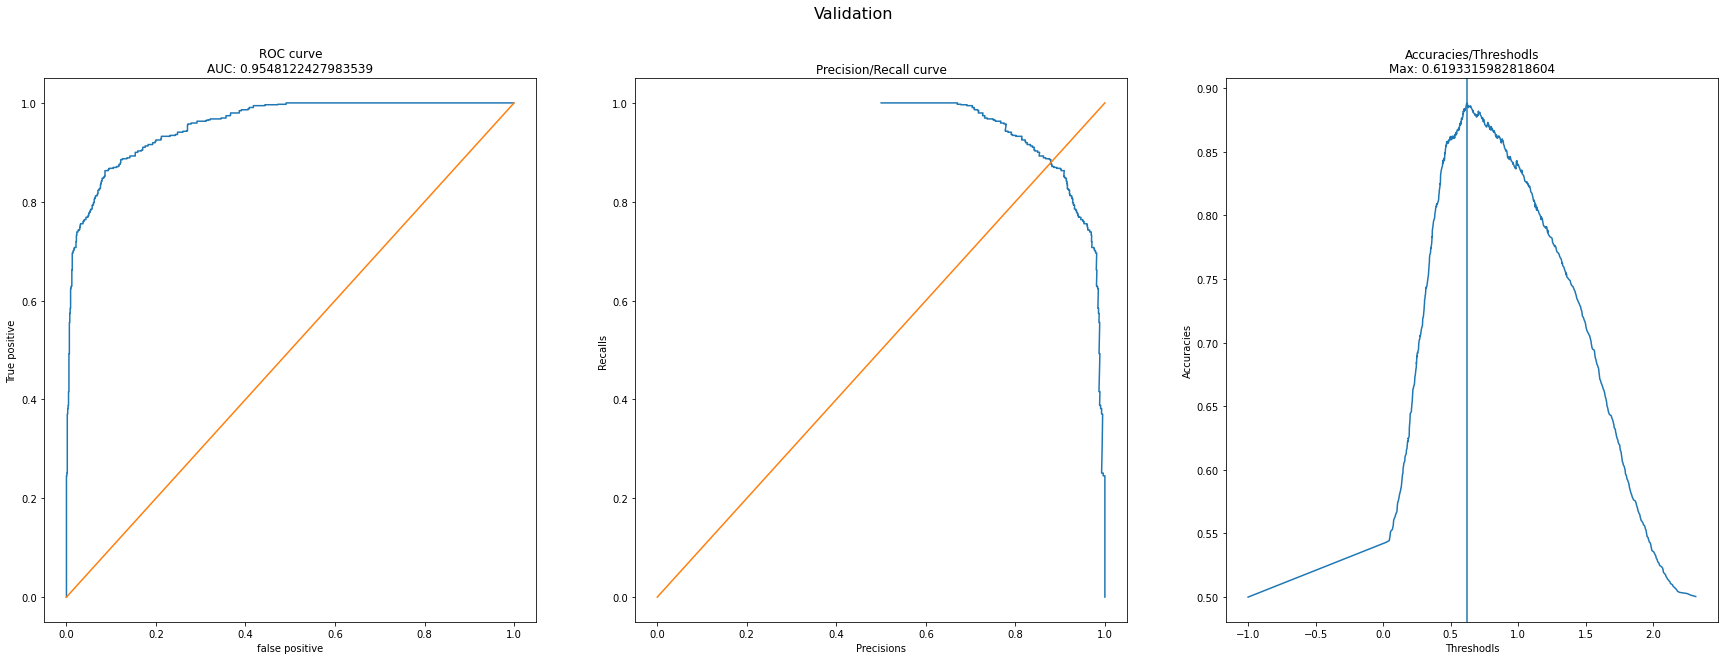

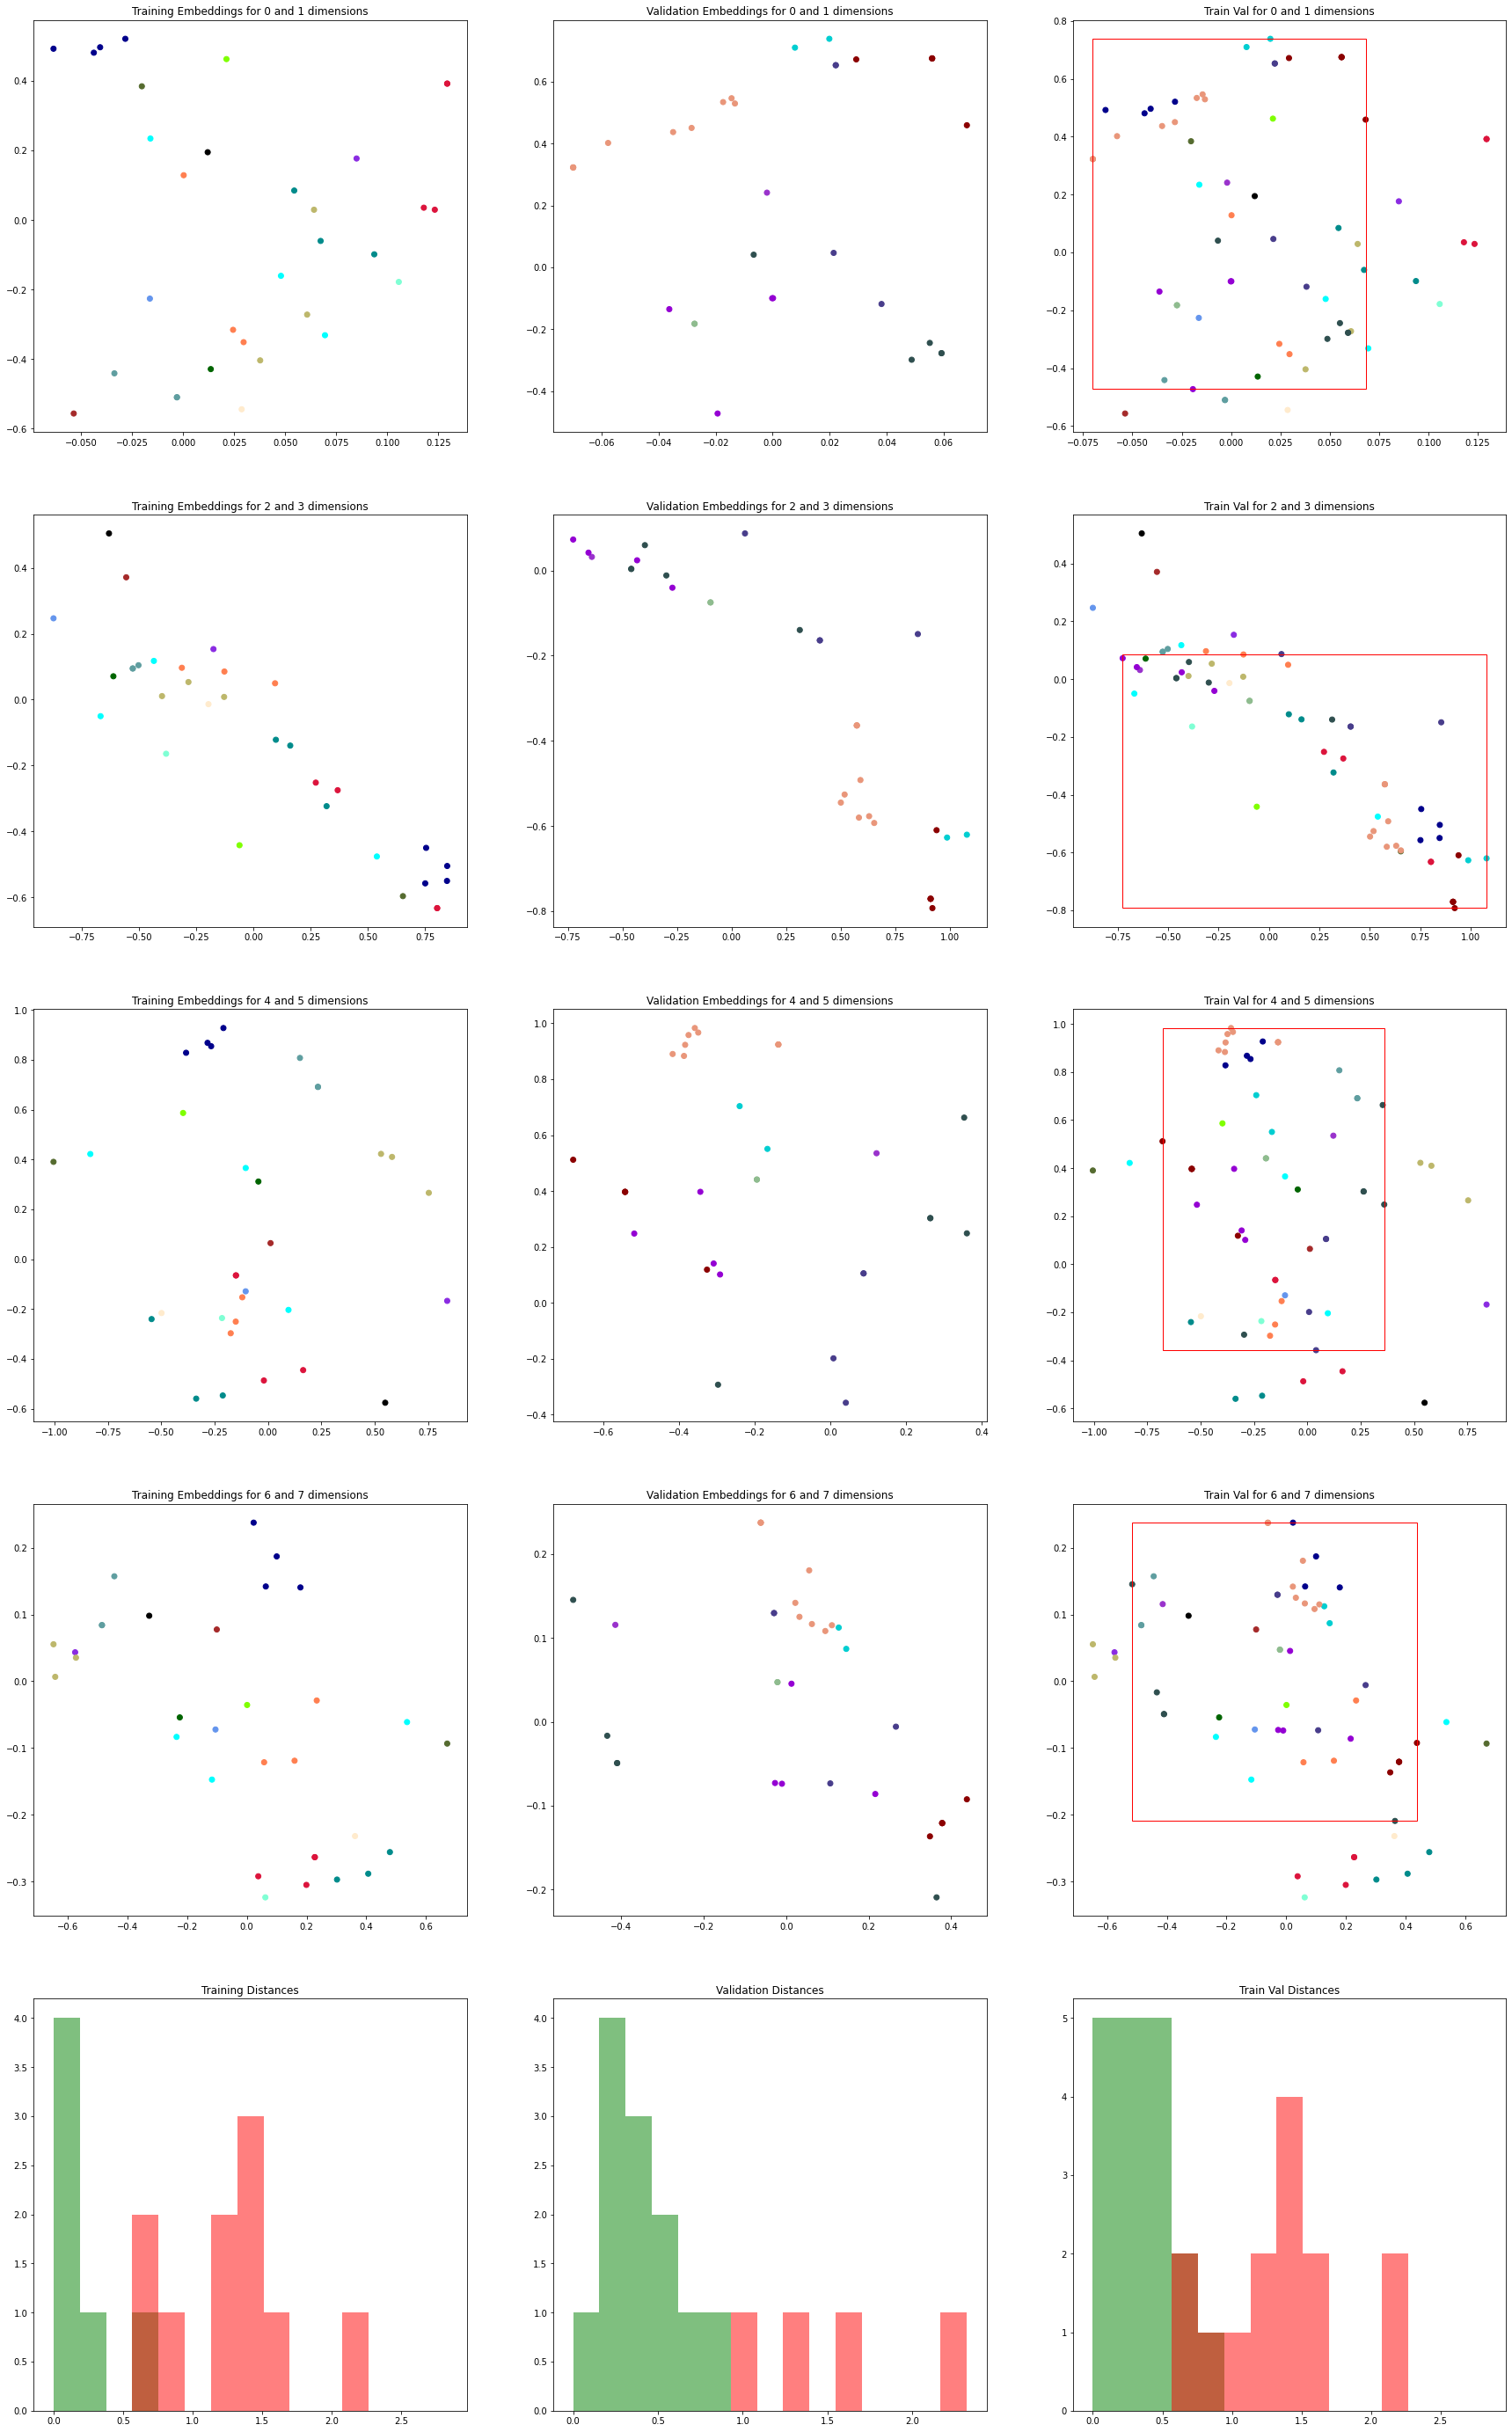

  0%|          | 0/5438 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Epoch: 2/100	Train Loss: 0.5147232413291931  :  57%|█████▋    | 3108/5438 [04:41<03:36, 10.74it/s]

In [ ]:
import os
import time
import math
from copy import deepcopy
import os.path as osp
import shutil
from prettytable import PrettyTable
import json
from sklearn.metrics import auc

from tqdm import tqdm

import numpy as np
import torch
from torch.cuda import amp
# from torch.utils.tensorboard import SummaryWriter

class Trainer:
    # -----------------------------------------------INITIALIZE TRAINING-------------------------------------------------------------
    def __init__(self, device=device, epochs=EPOCHS, batch_size=BATCH_SIZE, save_dir=SAVE_DIR, train_loader=train_dataloader, valid_loader=test_dataloader, weights=WEIGHTS, verbose=VERBOSE, visualize_plots=True, save_plots=True, model_name=MODEL_NAME):
        self.device = device
        self.save_dir = save_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_ema = False
        self.model_name = model_name
        self.weights = weights
        self.visualize_plots = visualize_plots
        self.save_plots = save_plots
        # 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters
        self.verbose = verbose
        self.train_losses=[]
        self.val_losses=[]
        self.conf = {'Name' : self.model_name, 'Bacth_size' : self.batch_size, 'Max_iter_num' : '', 'Epochs' : self.epochs, 'Trained_epoch' : 0, 'Optimizer' : '', "Model" : '', 'Parameter_size' : ''}

        temm=0
        tmp_save_dir = self.save_dir
        while osp.exists(tmp_save_dir):
            tmp_save_dir = self.save_dir
            temm+=1
            tmp_save_dir += (str(temm))
        self.save_dir = tmp_save_dir
        del temm


        # get data loader
        self.train_loader, self.valid_loader = train_loader, valid_loader
        self.max_stepnum = len(self.train_loader)
        self.conf["Max_iter_num"] = self.max_stepnum
        
        # get model 
        self.model = self.get_model()
        if self.verbose > 2:
            self.count_parameters()

        # Get optimizer
        self.optimizer = self.get_optimizer()

# ----------------------------------------------------INITIALIZERS-------------------------------------------------------------------------
    # Get Model 
    def get_model(self):
        # Get Model Archutecture From Model Class.
        model = SiameseNetwork().to(self.device)

        # finetune if pretrained model is set
        if self.weights:  
            print(f'Loading state_dict from {self.weights} for fine-tuning...')
            model.load_state_dict(torch.load(self.weights))
        # Log Model
        if self.verbose > 0:
            print('Model: {}'.format(model))
        self.conf["Model"] = str(model)
        return model

    def get_optimizer(self, optimizer="Adam", lr0=0.001, momentum=0.937):
        assert optimizer == 'SGD' or 'Adam', 'ERROR: unknown optimizer, use SGD defaulted'
        if optimizer == 'SGD':
            optim = torch.optim.SGD(self.model.parameters(), lr=lr0, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            optim = torch.optim.Adam(self.model.parameters(), lr=lr0, betas=(momentum, 0.999))

        if self.verbose > 1:
            print(f"{'optimizer:'} {type(optim).__name__}")
        self.conf['Optimizer'] = f"{'optimizer:'} {type(optim).__name__}"
        return optim

    # Loss Function Definition
    def compute_loss(self, output1, output2, label):
        criterion = ContrastiveLoss()
        loss = criterion(output1, output2, label)
        return loss

    def count_parameters(self):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in self.model.named_parameters():
            if not parameter.requires_grad: continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        self.conf["Parameter_size"] = total_params
# -------------------------------------------------------------------------------TRAINING PROCESS-----------------------------------------------
    @staticmethod
    def prepro_data(batch_data, device):
        images1 = batch_data[0].to(device)
        images2 = batch_data[1].to(device) 
        targets = batch_data[2].to(device)
        images1_class = batch_data[3].to(device)
        images2_class = batch_data[4].to(device)
        return images1, images2, targets, images1_class, images2_class

    # Each Train Step
    def train_step(self, batch_data):
        images1, images2, targets, images1_class, images2_class = self.prepro_data(batch_data, self.device)
        # forward
        with amp.autocast(enabled=self.device != 'cpu'):
            preds = self.model(images1, images2)
            loss, losses, dis = self.compute_loss(preds[0], preds[1], targets)
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())

        loss = loss + l2_lambda * l2_norm
        # backward
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        
        return loss.cpu().detach().numpy(), [pred.cpu().detach().numpy() for pred in preds], images1_class.cpu().detach().numpy(), images2_class.cpu().detach().numpy(), targets.cpu().detach().numpy()

    # Each Validation Step
    def val_step(self, batch_data):
        self.model.eval()
        images1, images2, targets, images1_class, images2_class = self.prepro_data(batch_data, self.device)

        # forward
        preds = self.model(images1, images2)
        loss, losses, dis = self.compute_loss(preds[0], preds[1], targets)
        return loss.cpu().detach().numpy(), [pred.cpu().detach().numpy() for pred in preds], images1_class.cpu().detach().numpy(), images2_class.cpu().detach().numpy(), targets.cpu().detach().numpy()

    # Training Process
    def train(self):
        try:
            # training process prerequisite
            self.start_time = time.time()
            print('Start Training Process \nTime: {}'.format(time.ctime(self.start_time)))
            self.scaler = amp.GradScaler(enabled=self.device != 'cpu')
            self.best_loss = np.inf

            # Epoch Loop
            for self.epoch in range(0, self.epochs):
                try:
                    self.conf["Trained_epoch"] = self.epoch

                    # Training loop
                    self.model.train(True)
                    pbar = enumerate(self.train_loader)
                    pbar = tqdm(pbar, total=self.max_stepnum)
                    for step, batch_data in pbar:
                        self.train_loss, embeds, images1_class, images2_class, targets = self.train_step(batch_data)
                        self.train_losses.append(self.train_loss)
                        pbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tTrain Loss: {self.train_loss}  ")
                    del pbar

                    # Train Validation Loop
                    training1_embeddings = []
                    training2_embeddings = []
                    images1_classes = []
                    images2_classes = []
                    labels = []

                    val_training1_embeddings = []
                    val_training2_embeddings = []
                    val_images1_classes = []
                    val_images2_classes = []
                    val_labels = []

                    tbar = enumerate(self.train_loader)
                    tbar = tqdm(tbar, total=self.max_stepnum)
                    for step, batch_data in tbar:
                        self.train_val_loss, embeds, images1_class, images2_class, targets = self.val_step(batch_data)
                        tbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tTrain Validation Loss: {self.train_val_loss} ")
                        training1_embeddings.extend(embeds[0])
                        training2_embeddings.extend(embeds[1])
                        images1_classes.extend(images1_class)
                        images2_classes.extend(images2_class)
                        labels.extend(targets)
                    del tbar

                    # Validation Loop
                    vbar = enumerate(self.valid_loader)
                    vbar = tqdm(vbar, total=len(self.valid_loader))
                    for step, batch_data in vbar:
                        self.val_loss, val_embeds, val_images1_class, val_images2_class, val_targets = self.val_step(batch_data)
                        self.val_losses.append(self.val_loss)
                        vbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tValidation Loss Loss: {self.val_loss}  ")
                        val_training1_embeddings.extend(val_embeds[0])
                        val_training2_embeddings.extend(val_embeds[1])
                        val_images1_classes.extend(val_images1_class)
                        val_images2_classes.extend(val_images2_class)
                        val_labels.extend(val_targets)
                    del vbar

                    # PLot Losses
                    self.plot_loss()

                    # calculate euclidean distances
                    euclidean_distance = np.linalg.norm((np.array(training1_embeddings) - np.array(training2_embeddings)), axis=1)
                    val_euclidean_distance = np.linalg.norm((np.array(val_training1_embeddings) - np.array(val_training2_embeddings)), axis=1)

                    # Evaluate 
                    # self.evaluation(euclidean_distance=euclidean_distance, labels=labels, title="Training")
                    self.evaluation(euclidean_distance=val_euclidean_distance, labels=val_labels, title="Validation")

                    # PLot Embeddings
                    plot_size = BATCH_SIZE
                    self.plot_embeddings(euclidean_distance, val_euclidean_distance, np.array(training1_embeddings), np.array(training2_embeddings), np.array(images1_classes), np.array(images2_classes), np.array(val_training1_embeddings), np.array(val_training2_embeddings), np.array(val_images1_classes), np.array(val_images2_classes), plot_size, plot_size)

                    # Delete Data after PLotting
                    del training1_embeddings, training2_embeddings, images1_classes, images2_classes, val_training1_embeddings, val_training2_embeddings, val_images1_classes, val_images2_classes
                    
                    if self.val_loss < self.best_loss:
                        self.best_loss=self.val_loss

                except Exception as _:
                    print('ERROR in training steps.')
                    raise
                try:
                    self.save()
                except Exception as _:
                    print('ERROR in evaluate and save model.')
                    raise
        except Exception as _:
            print('ERROR in training loop or eval/save model.')
            raise
        finally:
            finish_time = time.time()
            print(f'\nTraining completed in {time.ctime(finish_time)} \nIts Done in: {(time.time() - self.start_time) / 3600:.3f} hours.') 
    

    # -------------------------------------------------------Training Callback after each epoch--------------------------
    def plot_loss(self, train_mean_size=1, val_mean_size=1):
        COLS=3
        ROWS=1
        LINE_WIDTH = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        fig.suptitle("Losses Plot", fontsize=16)

        # train_mean_size = self.max_stepnum/self.batch_size
        ax[0].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[0].set_title("Training Loss")

        val_mean_size = len(self.valid_loader)
        ax[1].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[1].set_title("Validation Loss")

        train_mean_size = self.max_stepnum
        ax[2].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[2].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[2].set_title("Train Validation Loss")

        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-loss-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()

    def plot_embeddings(self, euclidean_distance, val_euclidean_distance, training1_embeddings, training2_embeddings, images1_classes, images2_classes, val_training1_embeddings, val_training2_embeddings, val_images1_classes, val_images2_classes, train_plot_size=0, val_plot_size=0):
        if train_plot_size > 0:
            training1_embeddings = np.array(training1_embeddings[:train_plot_size])
            training2_embeddings = np.array(training2_embeddings[:train_plot_size])
            images1_classes = np.array(images1_classes[:train_plot_size])
            images2_classes = np.array(images2_classes[:train_plot_size])
        if val_plot_size > 0:
            val_training1_embeddings = np.array(val_training1_embeddings[:val_plot_size])
            val_training2_embeddings = np.array(val_training2_embeddings[:val_plot_size])
            val_images1_classes = np.array(val_images1_classes[:val_plot_size])
            val_images2_classes = np.array(val_images2_classes[:val_plot_size])
        # print("Train embedding size : {} and val_training embedding size : {} image1_class size : {} image2_class size : {}".format(len(training1_embeddings), len(val_training1_embeddings), len(images1_classes), len(images2_classes)))
        # print(training1_embeddings, training1_embeddings[:, 0])

        COLS = 3
        ROWS = int(OUTPUT_EMBEDDING_SIZE / 2) + 1
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        # fig.suptitle("Embeddings Plot", fontsize=16)
        for dim in range(0, OUTPUT_EMBEDDING_SIZE, 2):
            ax[int(dim/2), 0].set_title("Training Embeddings for {} and {} dimensions".format(dim, dim+1))
            ax[int(dim/2), 0].scatter(training1_embeddings[:, dim], training1_embeddings[:, dim+1], c=get_colors(images1_classes))
            ax[int(dim/2), 0].scatter(training2_embeddings[:, dim], training2_embeddings[:, dim+1], c=get_colors(images2_classes))

            ax[int(dim/2), 1].set_title("Validation Embeddings for {} and {} dimensions".format(dim, dim+1))
            ax[int(dim/2), 1].scatter(val_training1_embeddings[:, dim], val_training1_embeddings[:, dim+1], c=get_colors(val_images1_classes))
            ax[int(dim/2), 1].scatter(val_training2_embeddings[:, dim], val_training2_embeddings[:, dim+1], c=get_colors(val_images2_classes))

            
            ax[int(dim/2), 2].set_title("Train Val for {} and {} dimensions".format(dim , dim+1))
            ax[int(dim/2), 2].scatter(training1_embeddings[:, dim], training1_embeddings[:, dim+1], c=get_colors(images1_classes))
            ax[int(dim/2), 2].scatter(training2_embeddings[:, dim], training2_embeddings[:, dim+1], c=get_colors(images2_classes))
            ax[int(dim/2), 2].scatter(val_training1_embeddings[:, dim], val_training1_embeddings[:, dim+1], c=get_colors(val_images1_classes))
            ax[int(dim/2), 2].scatter(val_training2_embeddings[:, dim], val_training2_embeddings[:, dim+1], c=get_colors(val_images2_classes))
    
        # Draw Rectangle
            rect_minx = min(np.min(val_training1_embeddings[:, dim]), np.min(val_training2_embeddings[:, dim]))
            rect_maxx = max(np.max(val_training1_embeddings[:, dim]), np.max(val_training2_embeddings[:, dim]))
            rect_miny = min(np.min(val_training1_embeddings[:, dim+1]), np.min(val_training2_embeddings[:, dim+1]))
            rect_maxy = max(np.max(val_training1_embeddings[:, dim+1]), np.max(val_training2_embeddings[:, dim+1]))
            rect=matplotlib.patches.Rectangle(xy=(rect_minx, rect_miny), width=rect_maxx-rect_minx, height=rect_maxy-rect_miny, linewidth=1, edgecolor='r', facecolor='none')
            ax[int(dim/2), 2].add_patch(rect)

        # Draw Histogram
        pos=[]
        neg=[]
        for index, label in enumerate(images1_classes):
            if label == images2_classes[index]:
                pos.append(euclidean_distance[index])
            elif label != images2_classes[index]:
                neg.append(euclidean_distance[index])

        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 0].set_title("Training Distances")
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 0].hist(pos, bins = 15,  alpha = 0.5, lw=3, color='g', range=(0, np.max(euclidean_distance)))
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 0].hist(neg, bins = 15,  alpha = 0.5, lw=3, color='r', range=(0, np.max(euclidean_distance)))

        val_pos=[]
        val_neg=[]
        for index, label in enumerate(val_images1_classes):
            if label == val_images2_classes[index]:
                val_pos.append(val_euclidean_distance[index])
            elif label != val_images2_classes[index]:
                val_neg.append(val_euclidean_distance[index])

        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 1].set_title("Validation Distances")
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 1].hist(val_pos, bins = 15, alpha = 0.5, lw=3, color='g', range=(0, np.max(val_euclidean_distance)))
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 1].hist(val_neg, bins = 15, alpha = 0.5, lw=3, color='r', range=(0, np.max(val_euclidean_distance)))

        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 2].set_title("Train Val Distances")
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 2].hist(np.concatenate([pos, val_pos]), bins = 15, alpha = 0.5, lw=3, color='g', range=(0, max(np.max(euclidean_distance), np.max(val_euclidean_distance))))
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 2].hist(np.concatenate([neg, val_neg]), bins = 15, alpha = 0.5, lw=3, color='r', range=(0, max(np.max(euclidean_distance), np.max(val_euclidean_distance))))

        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()

    def evaluation(self, euclidean_distance, labels, title):
        true_pose_rate = []
        false_pose_rate = []
        precisions = []
        recalls = []
        f1_scores = []
        thresholds = []
        accs = []

        sorted_distances = np.sort(np.unique(euclidean_distance))

        for index, dis in enumerate(sorted_distances):
            if index == 0:
                threshold = -1.0
                thresholds.append(threshold)
            else:
                threshold = (dis + sorted_distances[index-1]) / 2.0
                thresholds.append(threshold)
            true_pos = 0
            false_pos = 0
            true_neg = 0
            false_neg = 0
            for i, label in enumerate(labels):
                if label == 0:
                    if euclidean_distance[i] < threshold:
                        true_pos += 1
                    else:
                        false_neg += 1
                elif label == 1:
                    if euclidean_distance[i] > threshold:
                        true_neg += 1
                    else:
                        false_pos += 1
            
            true_pose_rate.append(true_pos / (true_pos + false_neg))
            false_pose_rate.append(false_pos / (true_neg + false_pos))

            acc = (true_pos + true_neg) / (true_neg + false_neg + true_pos + false_pos)
            precision = 1 if true_pos + false_pos == 0 else true_pos / (true_pos + false_pos)
            recall = true_pos / (true_pos + false_neg)
            f1_score = 2 * (recall * precision) / (recall + precision  + 0.000001)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1_score)
            accs.append(acc)

        # print(thresholds)
        # print(true_pose_rate)
        # print(false_pose_rate)

        # idx = np.argsort(np.array(false_pose_rate))
        # false_pose_rate = np.array(false_pose_rate)[idx]
        # true_pose_rate = np.array(true_pose_rate)[idx]
        roc_auc = auc(false_pose_rate, true_pose_rate)
        
        COLS = 3
        ROWS = 1
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        fig.suptitle(title, fontsize=16)
        ax[0].plot(false_pose_rate, true_pose_rate)
        ax[0].plot([0, 1])
        ax[0].set_xlabel('false positive')
        ax[0].set_ylabel('True positive')
        ax[0].set_title("ROC curve\nAUC: {}".format(roc_auc))
        # print("AUC: {}".format())

        ax[1].plot(precisions, recalls)
        ax[1].plot([0, 1])
        ax[1].set_xlabel('Precisions')
        ax[1].set_ylabel('Recalls')
        ax[1].set_title("Precision/Recall curve")
        # print("AUC : {}".format(self.calc_area(false_pose_rate, true_pose_rate)))


        ax[2].plot(thresholds, accs)
        ax[2].set_xlabel('Threshodls')
        ax[2].set_ylabel('Accuracies')
        ax[2].axvline(x=thresholds[np.argmax(accs)])
        ax[2].set_title("Accuracies/Threshodls\nMax: {}".format(thresholds[np.argmax(accs)]))
        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'evaluation') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()
        return roc_auc
    
    # -------------------------------------------------------save Model-------------------------------------------
    def save(self):
        # create config object
        conf = json.dumps(self.conf)
        f = open(self.save_dir + "/config.json","w")
        f.write(conf)
        f.close()
        # save model
        save_ckpt_dir = osp.join(self.save_dir, 'weights')
        if not osp.exists(save_ckpt_dir):
            os.makedirs(save_ckpt_dir)
        filename = osp.join(save_ckpt_dir, self.model_name + "-" + str(self.epoch) + '.pt')
        torch.save(self.model.state_dict(), filename)
        if self.val_loss == self.best_loss:
            best_filename = osp.join(save_ckpt_dir, 'best_{}.pt'.format(self.model_name, self.epoch))
            if osp.exists(best_filename):
                os.remove(best_filename)
            shutil.copyfile(filename, best_filename)

    # ----------------------------------------------------Run Model---------------------
    def run(self, input1, input2):
        self.model.eval()
        img0 = Image.open(input1)
        img1 = Image.open(input2)

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        image_tensor1 = transformation(img0).div_(255).float()
        image_tensor2 = transformation(img1).div_(255).float()

        fig, ax = plt.subplots(1,2)
        ax[0].imshow(img0)
        ax[1].imshow(img1)
        plt.show()
        
        preds = self.model(image_tensor1.unsqueeze(0), image_tensor2.unsqueeze(0))
        euclidean_distance = F.pairwise_distance(preds[0], preds[1], keepdim = True)
        print(preds, euclidean_distance)

        if euclidean_distance > 0.1:
            print("Different Person Images Identified!")
        else: 
            print("Same Person Images Identified!")

Trainer(batch_size=BATCH_SIZE, device=device, epochs=100, verbose=10).train()
# Trainer(batch_size=32, device="cpu", epochs=50, verbose=0, weights="/content/runs/weights/best_SSL_epoch_45.pt").run("/content/data/faces/testing/s5/2.pgm", "/content/data/faces/testing/s7/4.pgm")